# Faster R-CNN (ResNet50-FPN, Pretrained ImageNet) on C2A_Dataset

- Two-stage detector
- Backbone: ResNet50 + FPN (pretrained=ImageNet)
- RPN: Generate Regions
- RoI Pooling + FC Layers
- Optimizer: SGD
- Loss: Multi-task Loss (RPN obj + RPN bbox + ROI cls + ROI bbox)

This notebook sets up a Faster R-CNN model, runs quick inference, and visualizes: 
- Feature map heatmaps from 3 layers (ResNet layer1/layer2/layer3)
- Dense layer activations (fc6, fc7 in ROI head) as bar plots
for at least 5 images (3 similar results, 2 different).

In [58]:
%pip install -q torchvision matplotlib --quiet
import os, json, random, math
from collections import defaultdict, Counter
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Note: you may need to restart the kernel to use updated packages.
Using device: cuda


## Dataset: COCO-style JSON in C2A_Dataset/new_dataset3
We will read `train/val/test` splits from COCO-style JSONs (`*_annotations.json`) and image folders.
For simplicity, all categories are treated as class `1` (person) to match a 1-class detector (background+1).

In [59]:
DATASET_ROOT = './C2A_Dataset/new_dataset3'

class CocoSimpleDataset(Dataset):
    def __init__(self, root, split='test', transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        img_dir = os.path.join(root, split, 'images')
        ann_path = os.path.join(root, split, f'{split}_annotations.json')
        assert os.path.exists(img_dir), f'Missing {img_dir}'
        assert os.path.exists(ann_path), f'Missing {ann_path}'
        with open(ann_path, 'r') as f:
            data = json.load(f)
        # index images
        self.images = {im['id']: im for im in data.get('images', [])}
        # group annotations per image
        anns_per_img = defaultdict(list)
        for ann in data.get('annotations', []):
            anns_per_img[ann['image_id']].append(ann)
        self.ids = list(self.images.keys())
        self.img_dir = img_dir
        self.anns_per_img = anns_per_img
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.images[img_id]
        path = os.path.join(self.img_dir, info['file_name'])
        img = Image.open(path).convert('RGB')
        # Build boxes (COCO bbox is [x,y,w,h]) and labels (map any category to 1)
        boxes, labels = [], []
        for a in self.anns_per_img.get(img_id, []):
            x,y,w,h = a['bbox']
            boxes.append([x, y, x+w, y+h])
            labels.append(1)
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if len(boxes)>0 else torch.zeros((0,4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if len(labels)>0 else torch.zeros((0,), dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torchvision.transforms.ToTensor()(img)  # 0..1 tensor
        return img, target

In [60]:
# Build datasets and loaders
transform = torchvision.transforms.ToTensor()
train_ds = CocoSimpleDataset(DATASET_ROOT, 'train', transform)
val_ds = CocoSimpleDataset(DATASET_ROOT, 'val', transform)
test_ds = CocoSimpleDataset(DATASET_ROOT, 'test', transform)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
len(train_ds), len(val_ds), len(test_ds)

(6129, 2043, 2043)

## Model: Faster R-CNN with ResNet50-FPN (pretrained=ImageNet)
Optimizer: SGD, Loss: multi-task (built-in).

In [61]:
# Create pretrained backbone and model
backbone = resnet_fpn_backbone('resnet50', pretrained=True, trainable_layers=3)
num_classes = 2  # background + 1 class
model = FasterRCNN(backbone, num_classes=num_classes)
model.to(device)

# Optimizer (SGD)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002, momentum=0.9, weight_decay=5e-4)
print('Model ready')

Model ready


## Optional: quick warm-up training (few iterations)
You can skip this if only visualization is needed.

In [62]:
def train_steps(model, optimizer, loader, device, max_steps=20):
    model.train()
    steps = 0
    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        optimizer.step()
        steps += 1
        if steps % 5 == 0:
            print(f'Step {steps}: loss={loss.item():.4f}')
        if steps >= max_steps:
            break

# Uncomment to run a tiny warm-up
# train_steps(model, optimizer, train_loader, device, max_steps=10)

## Visualization hooks: feature maps (layer1, layer2, layer3) and dense activations (fc6, fc7)

In [63]:
feature_maps = {}
dense_acts = {}  # will hold 'fc6' and 'fc7' activations per image

# Register hooks on backbone ResNet layers
def save_fmap(name):
    def hook(module, inp, out):
        feature_maps[name] = out.detach().cpu()
    return hook

# Access resnet body inside backbone
resnet_body = model.backbone.body
h1 = resnet_body.layer1.register_forward_hook(save_fmap('layer1'))
h2 = resnet_body.layer2.register_forward_hook(save_fmap('layer2'))
h3 = resnet_body.layer3.register_forward_hook(save_fmap('layer3'))

# Hooks for ROI head dense layers (TwoMLPHead: fc6, fc7)
def save_dense(name):
    def hook(module, inp, out):
        # out shape: [num_rois, 1024]
        dense_acts[name] = out.detach().cpu()
    return hook

h_fc6 = model.roi_heads.box_head.fc6.register_forward_hook(save_dense('fc6'))
h_fc7 = model.roi_heads.box_head.fc7.register_forward_hook(save_dense('fc7'))
print('Hooks registered')

Hooks registered


## Helper functions: predict, heatmaps, and activation plots

In [64]:
def tensor_to_np(img_tensor):
    # img_tensor: [C,H,W] in 0..1
    img = img_tensor.detach().cpu().permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)
    return img

@torch.no_grad()
def run_inference_with_hooks(model, img_tensor):
    model.eval()
    preds = model([img_tensor.to(device)])  # triggers hooks
    return preds[0]

def show_feature_maps(fmaps, titles=('layer1','layer2','layer3')):
    plt.figure(figsize=(15,4))
    for i, k in enumerate(titles):
        fmap = fmaps[k]  # [B?, C, H, W] or [C,H,W] depending
        if fmap.dim() == 4:
            fmap = fmap[0]
        heat = fmap.mean(dim=0).numpy()  # channel-mean
        plt.subplot(1,3,i+1)
        plt.imshow(heat, cmap='hot')
        plt.title(k)
        plt.axis('off')
    plt.tight_layout(); plt.show()

def show_dense_activations(dacts, topk=32):
    # Show bar plots for fc6 and fc7 (top-k absolute activations)
    plt.figure(figsize=(16,5))
    for i, k in enumerate(['fc6','fc7']):
        act = dacts.get(k)
        if act is None or act.numel() == 0:
            vals = np.zeros(topk)
        else:
            vec = act[0].numpy()  # take first ROI
            idxs = np.argsort(-np.abs(vec))[:topk]
            vals = vec[idxs]
        plt.subplot(1,2,i+1)
        plt.bar(range(len(vals)), vals)
        plt.title(f'{k} top-{topk} activations')
        plt.xlabel('unit index (sorted)'); plt.ylabel('activation')
    plt.tight_layout(); plt.show()

def draw_detections(ax, img_np, pred, score_thr=0.5):
    ax.imshow(img_np); ax.axis('off')
    boxes = pred['boxes'].cpu().numpy() if pred['boxes'].numel()>0 else []
    scores = pred['scores'].cpu().numpy() if 'scores' in pred else []
    for b, s in zip(boxes, scores):
        if s < score_thr: continue
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f'{s:.2f}', color='yellow', fontsize=8, backgroundcolor='black')

def signature(pred):
    # simple signature: (det_count_above_0.5, avg_score_above_0.5)
    if 'scores' not in pred or pred['scores'].numel()==0:
        return (0, 0.0)
    scores = pred['scores'].cpu().numpy()
    m = scores >= 0.5
    cnt = int(m.sum())
    avg = float(scores[m].mean()) if cnt>0 else 0.0
    return (cnt, avg)

## Select 5 images (3 similar results, 2 different) and visualize

Selected indices: [217, 383, 817, 115, 1081]  (first 3 similar)


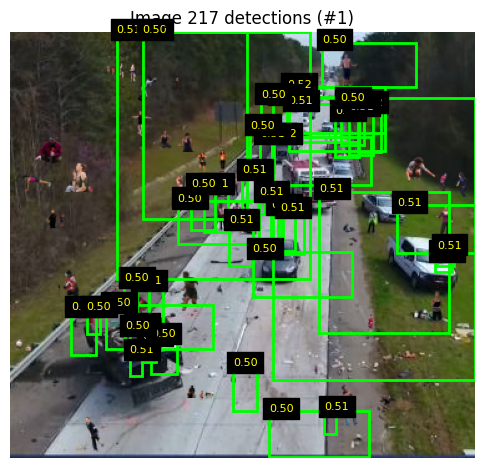

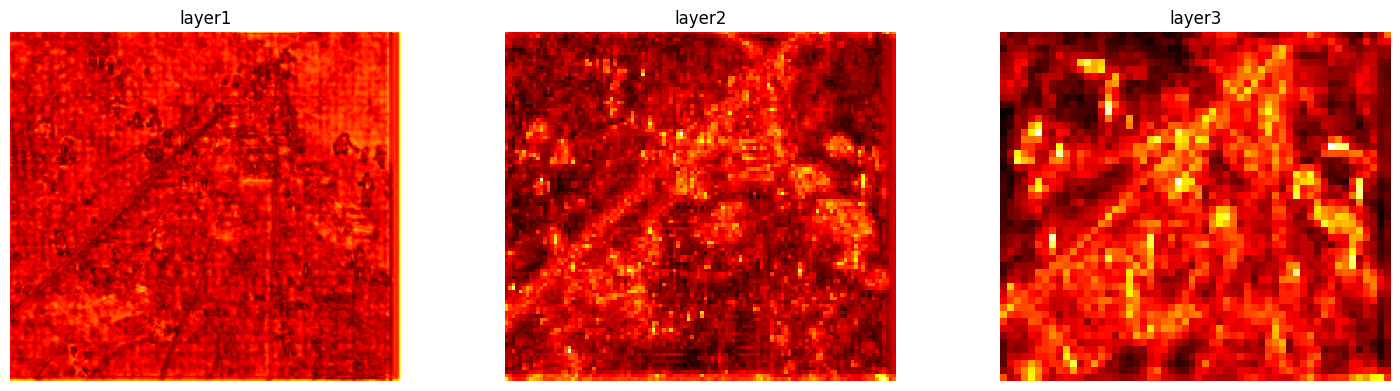

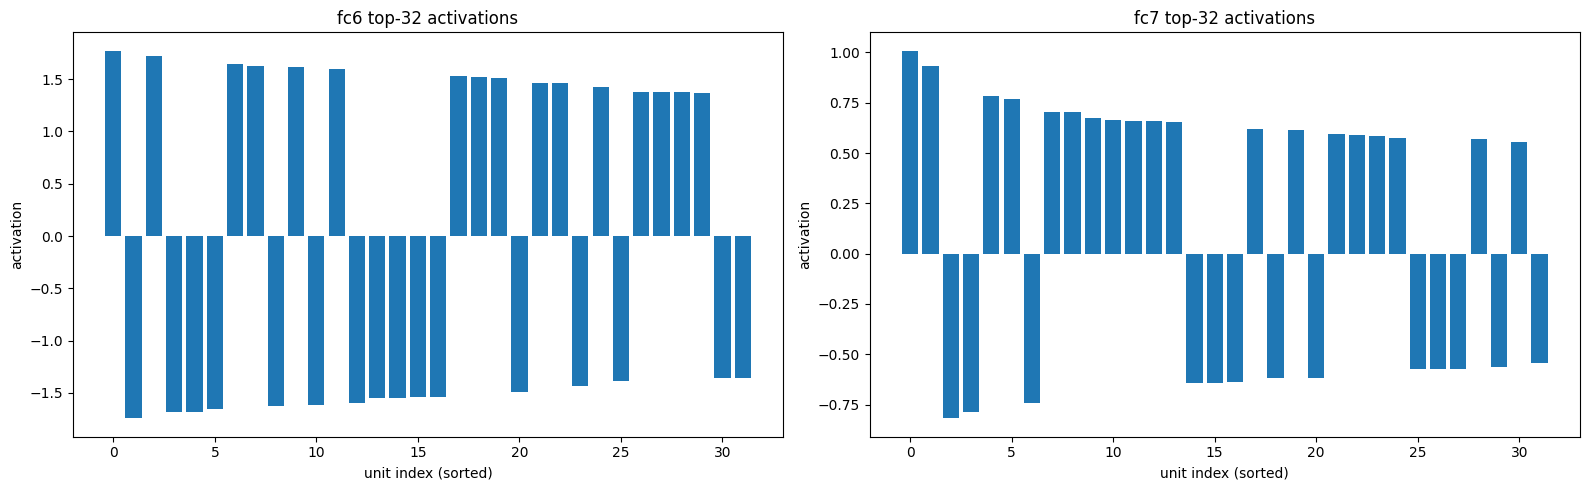

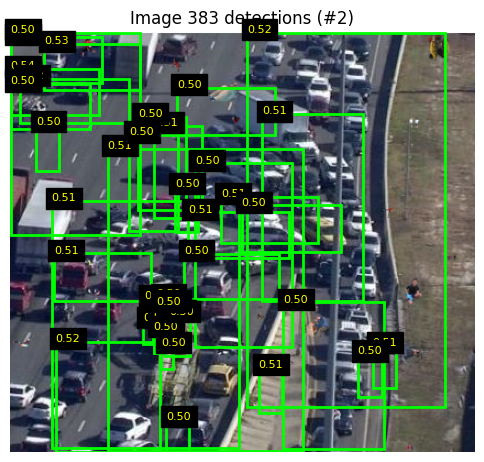

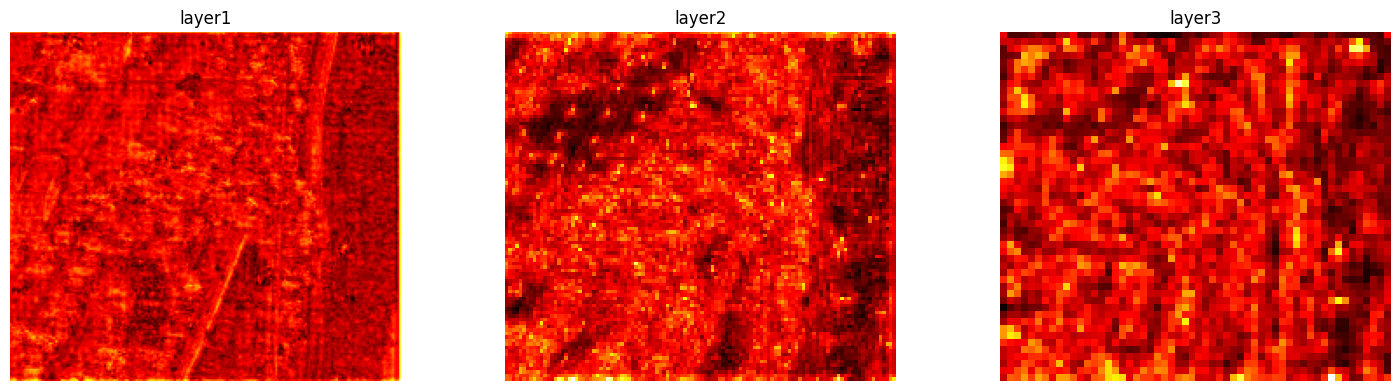

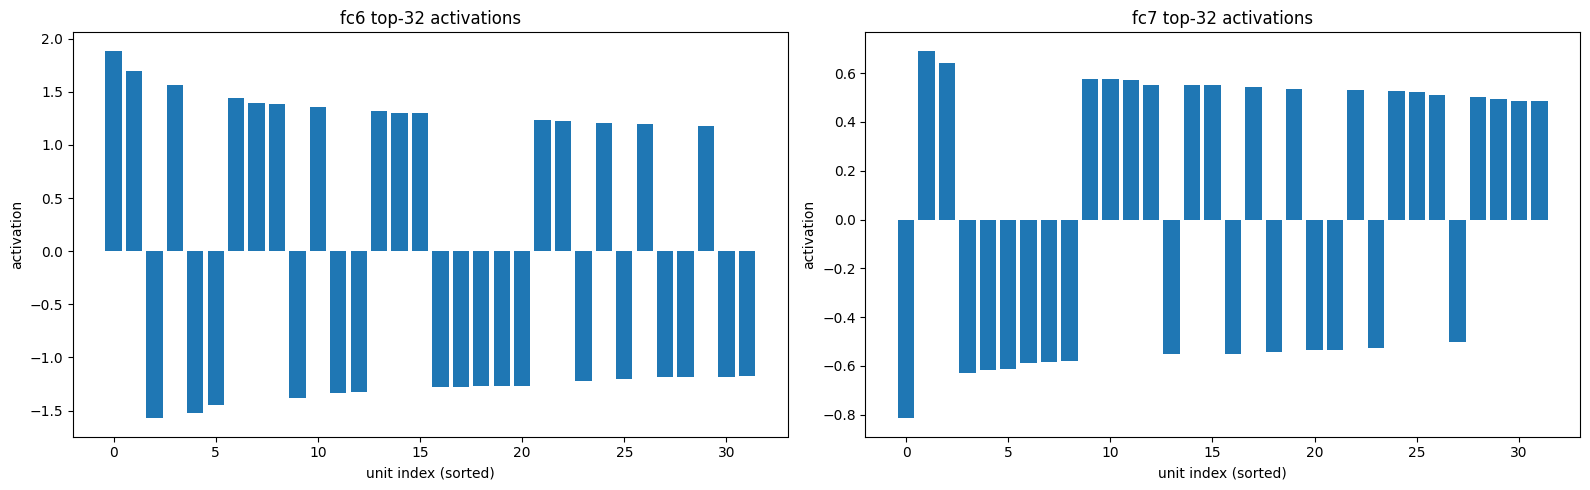

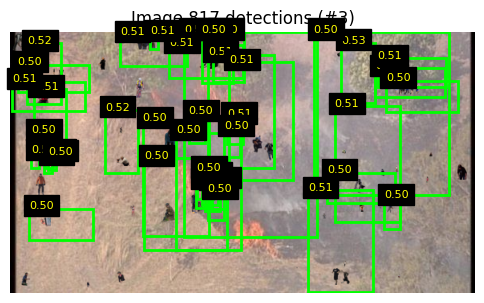

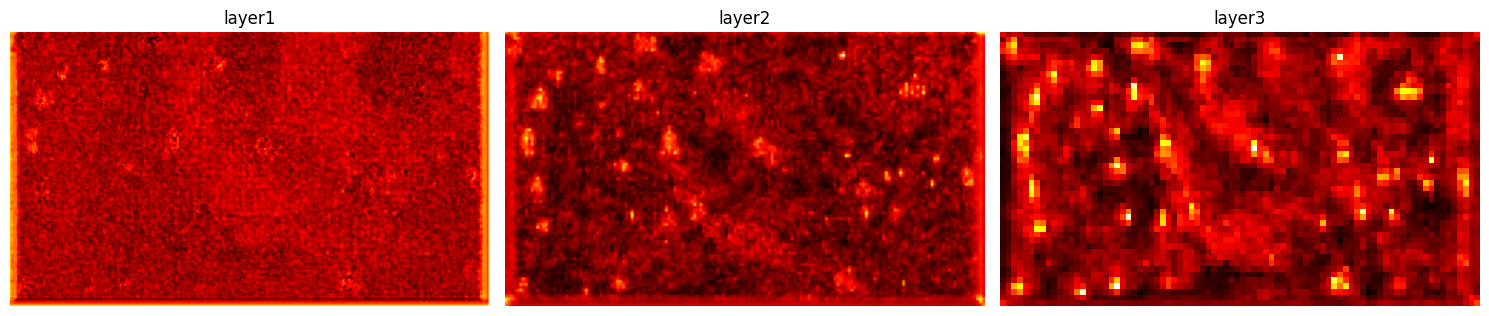

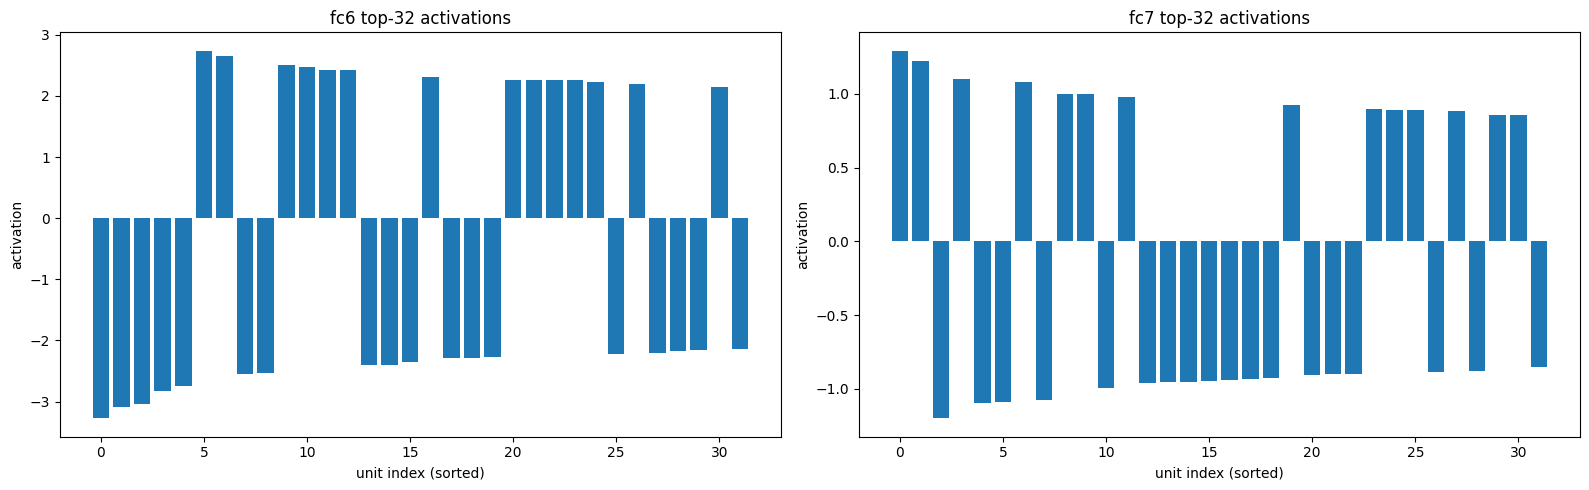

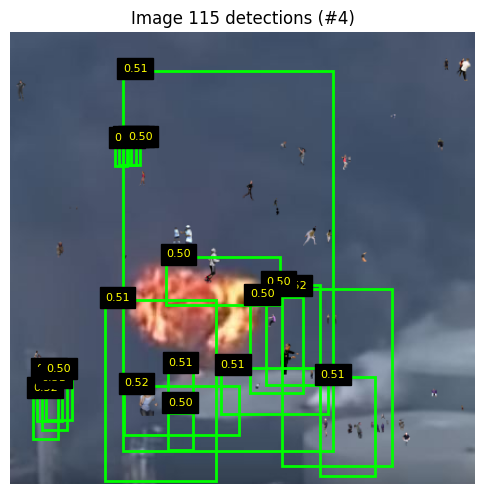

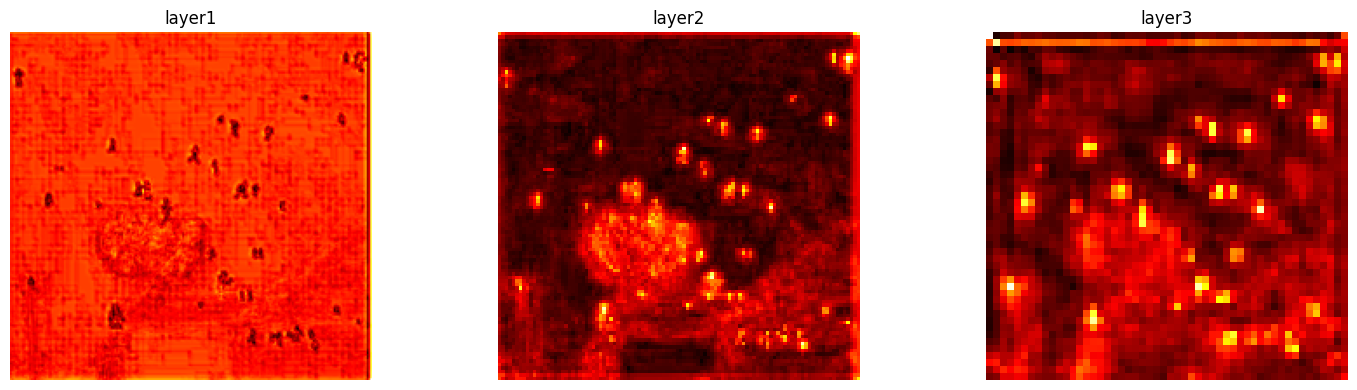

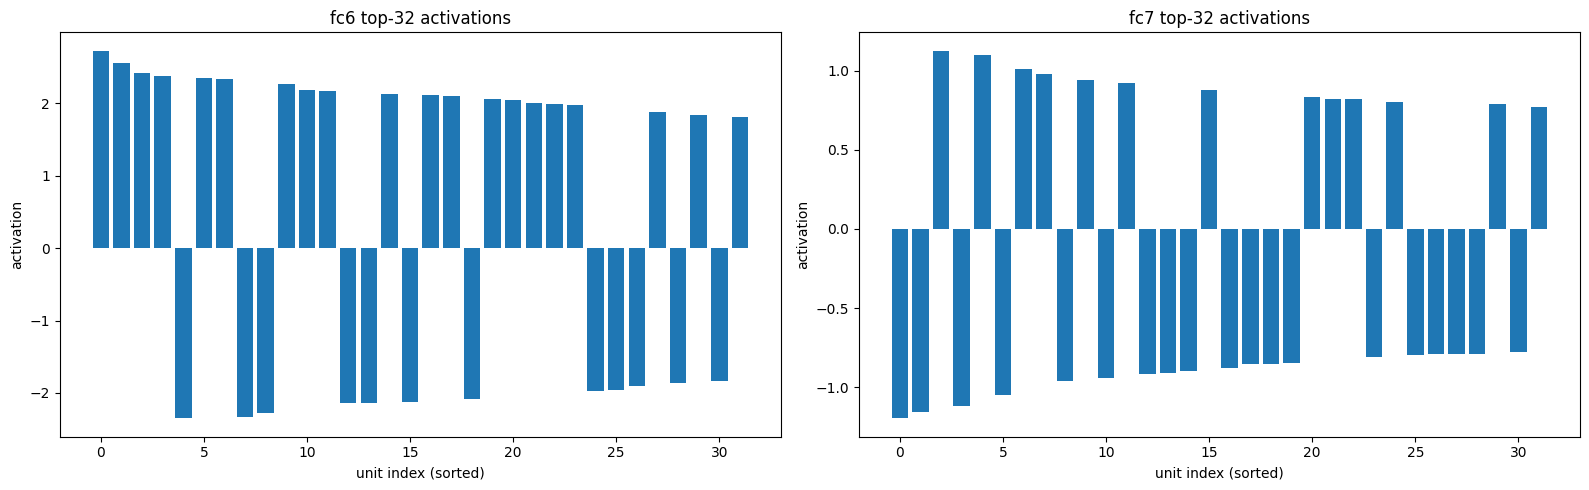

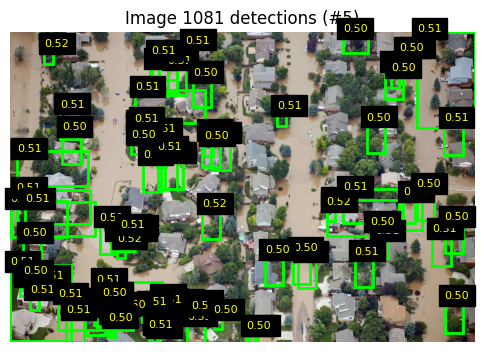

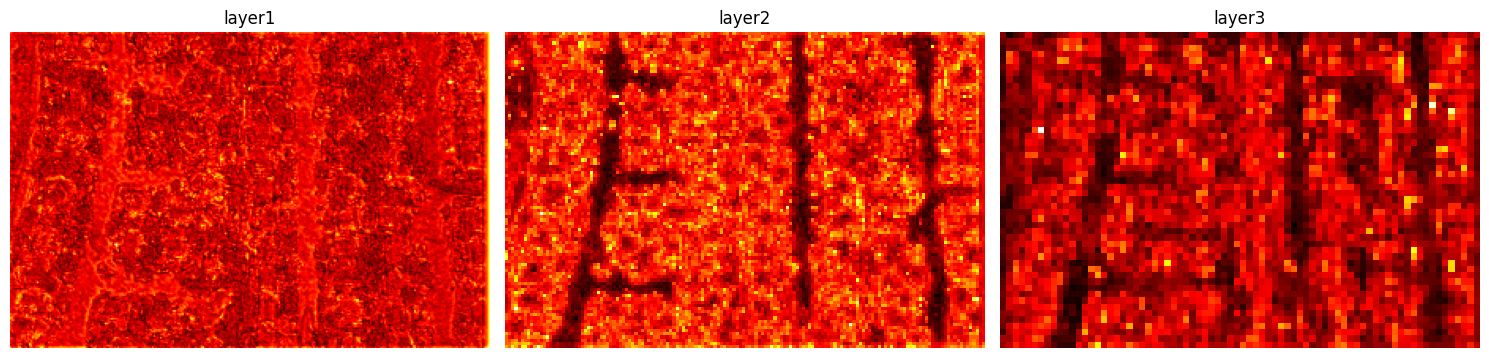

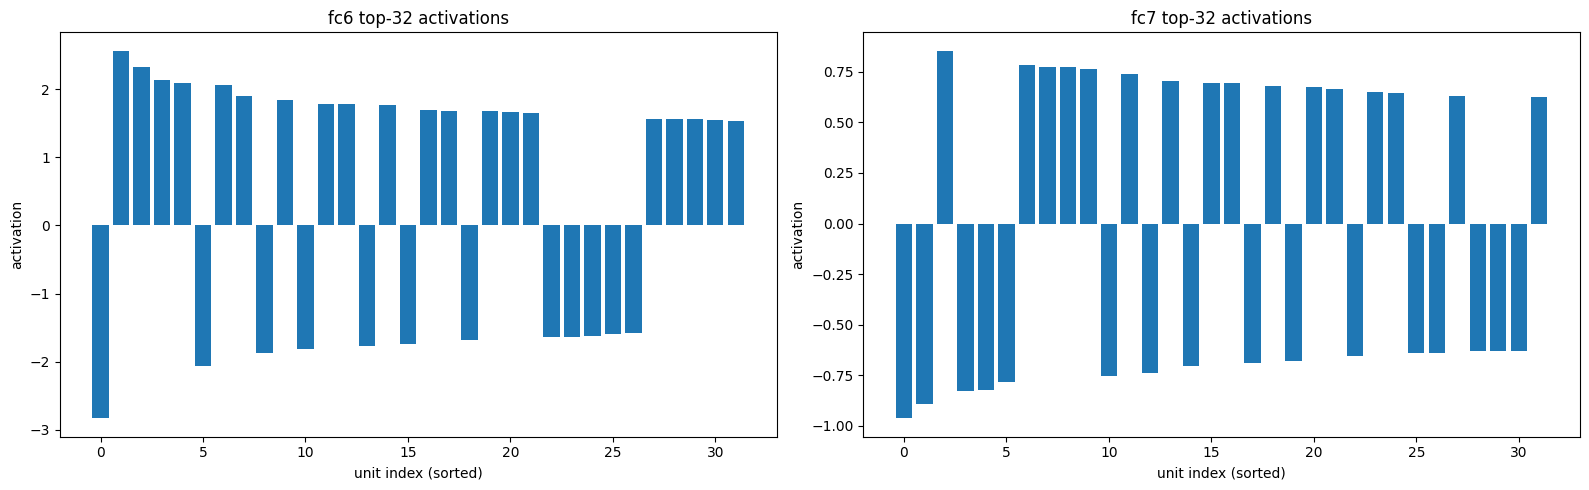

In [65]:
# Gather candidates from test set
indices = list(range(len(test_ds)))
random.seed(0)
random.shuffle(indices)

sigs = []  # (idx, cnt, avg)
for idx in indices[:50]:  # up to 50 candidates
    img, _ = test_ds[idx]
    pred = run_inference_with_hooks(model, img)
    cnt, avg = signature(pred)
    sigs.append((idx, cnt, avg))

# Choose 3 with the most common count
counts = [c for (_,c,_) in sigs]
if len(counts)==0:
    raise RuntimeError('No predictions to cluster; check dataset/images')
common_cnt = Counter(counts).most_common(1)[0][0]
similar = [idx for (idx,c,_) in sigs if c==common_cnt][:3]
# Choose 2 different: one with min count, one with max count (different from common if possible)
min_cnt = min(counts); max_cnt = max(counts)
diff = []
for target_cnt in [min_cnt, max_cnt]:
    cand = [idx for (idx,c,_) in sigs if c==target_cnt and idx not in similar]
    if cand:
        diff.append(cand[0])
# If not enough different, pad from remaining
rest = [idx for (idx,_,_) in sigs if idx not in similar and idx not in diff]
while len(diff) < 2 and rest:
    diff.append(rest.pop(0))

selected = similar + diff[:2]
print('Selected indices:', selected, ' (first 3 similar)')

# Visualize each selected image: detections, 3 heatmaps, and dense activations
for rank, idx in enumerate(selected, 1):
    img_t, _ = test_ds[idx]
    pred = run_inference_with_hooks(model, img_t)
    img_np = tensor_to_np(img_t)
    
    # Show detections
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    draw_detections(ax, img_np, pred, score_thr=0.5)
    ax.set_title(f'Image {idx} detections (#{rank})')
    plt.show()
    
    # Feature map heatmaps (3 layers)
    show_feature_maps(feature_maps, titles=('layer1','layer2','layer3'))
    
    # Dense layer activations (fc6, fc7)
    show_dense_activations(dense_acts, topk=32)